In [1]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import numpy as np


def mark_sequences(binary_array, k):
    count = 0
    start_index = None
    for i in range(len(binary_array)):
        if binary_array[i] == 1:
            if count == 0:
                start_index = i
            count += 1
            if count > k:
                binary_array[start_index+1:i+1] = 0
        else:
            if count <= k and start_index is not None:
                binary_array[start_index:i] = 0
            count = 0
            start_index = None
    # Handle the last sequence of 1s
    if count <= k and start_index is not None:
        binary_array[start_index:i+1] = 0
    return binary_array


def eval(predictions, targets, k=None):
    thresholds = np.arange(0, 1, 0.01).tolist()

    precisions = []
    recalls = []
    specificities = []
    fpr_ls = []


    for threshold in thresholds:
        out = []
        ground_truth = []
        for i in range(predictions.shape[0]):

            target = targets[i]
            predicted = predictions[i]

            predicted_thresholded = (predicted > threshold).astype(int)

            last_index = np.where(target == 100000.0)[0]
            if last_index.size != 0:
                last_index = last_index[0]
                target = target[:last_index]
            else:
                last_index = None

            assert np.sum(target == 100000.0) == 0

            if k != None:
                predicted_thresholded = mark_sequences(predicted_thresholded, k)

            #predicted_thresholded = predicted_thresholded[36:] # mute first two hours of predictions
            
            if np.sum(target == 1.0) > 0: # positive patient

                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                ground_truth.append(1)
                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)
            elif np.sum(target == 1.0) == 0: # negative patient
                ground_truth.append(0)
                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)

        
        if threshold == 0.5:
            print(confusion_matrix(ground_truth, out))
            print(classification_report(ground_truth, out))

        tn, fp, fn, tp = confusion_matrix(ground_truth, out).ravel()
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        specificity = tn / (tn + fp)

        precisions.append(precision)
        recalls.append(recall)
        specificities.append(specificity)
        fpr_ls.append(1 - specificity)

    # Use a list comprehension to filter out pairs where either value is NaN
    filtered_pairs = [(x, y) for x, y in zip(precisions, recalls) if not (np.isnan(x) or np.isnan(y))]

    # Split the filtered pairs back into two lists
    precision_no_nan, recalls_no_nan = zip(*filtered_pairs)

    auroc = auc(fpr_ls, recalls)
    print("AUROC: " + str(auroc))

    auprc = auc(recalls_no_nan, precision_no_nan)
    print("AUPRC: " + str(auprc))

    # Create a new figure
    plt.figure(figsize=(12, 6))

    # First subplot for the Precision-Recall Curve
    plt.subplot(1, 2, 1)
    plt.plot(recalls, precisions, marker='.')
    plt.xlabel('Recall')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')

    # Second subplot for the Receiver Operating Curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr_ls, recalls, marker='.')
    plt.ylabel('Sensitivity (Recall / TPR)')
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.xlabel('1 - Specificity (FPR)')
    plt.title('Receiver Operating Curve')

    # Display the plots
    plt.tight_layout()
    plt.show()

    return precisions, recalls, specificities, fpr_ls

In [7]:
def alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls):

    recalls_target = [0.9, 0.8, 0.7, 0.6, 0.5]
    precisions_target = []
    median_onset = []

    for target_recall in recalls_target:

        closest_index = min(range(len(recalls)), key=lambda index: abs(recalls[index]-target_recall))
        thresholds = np.arange(0, 1, 0.01).tolist()
        target_threshold = thresholds[closest_index] # 0.45 is the threshold for 80% recall in this case
        target_threshold

        out = []
        ground_truth = []
        times_to_onset = []
        for i in range(len(final_patients)):

            target = targets[i]
            predicted = predictions[i]

            predicted_thresholded = (predicted > target_threshold).astype(int)

            last_index = np.where(target == 100000.0)[0]
            if last_index.size != 0:
                last_index = last_index[0]
                target = target[:last_index]
            else:
                last_index = None

            assert np.sum(target == 100000.0) == 0
            
            if np.sum(target == 1.0) > 0: # positive patient

                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                onset_index = int((labels_file[labels_file['Patient_ID'] == final_patients[i]]['Onset_Index'].values[0]))

                ground_truth.append(1)
                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                    earliest_alarm = np.argmax(predicted_thresholded == 1)
                    time_to_onset = onset_index - earliest_alarm
                    times_to_onset.append(time_to_onset/2)
                else:
                    out.append(0)
            elif np.sum(target == 1.0) == 0: # negative patient
                ground_truth.append(0)
                if last_index != None:
                    predicted_thresholded = predicted_thresholded[:last_index]

                if np.sum(predicted_thresholded) > 0:
                    out.append(1)
                else:
                    out.append(0)

        median_onset.append(times_to_onset)
        precisions_target.append(precisions[closest_index])

    precisions_target = [round(item, 2) for item in precisions_target]
    recalls_target = [round(item, 2) for item in recalls_target]

    median_to_plot = [np.median(item) for item in median_onset]

    # Zip the two lists and convert them to string for plotting
    x_values = list(map(str, zip(recalls_target, precisions_target)))
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.bar(x_values, median_to_plot)
    plt.xlabel('(Recall, Precision) in %')
    plt.ylabel('Median Alarm Earliness in Hours')
    plt.title('Bar plot of Median Alarm Earliness against Recall and Precision')
    print(median_to_plot)
    x_values = list(map(str, zip(recalls_target, precisions_target)))
    plt.subplot(1, 2, 2)
    plt.boxplot(median_onset, showfliers=False)
    plt.xticks(range(1, len(x_values) + 1), x_values)
    plt.xlabel('(Recall, Precision) in %')
    plt.ylabel('First Alarm to Onset Time in Hours')
    plt.grid(True)

    plt.grid(True, which='minor', linestyle=':', linewidth=0.5)

    plt.title('Spread of First Alarm to Onset Time against Recall and Precision of Model, Respiratory Failure')
    plt.tight_layout()
    plt.show()

## KIDNEY - MIMIC

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

root_path = '/datasets/amelatur/whole_sequences/kidney/k_fold/fold_4/'

predictions = np.load(root_path + 'raw_preds_online_lstm_6_24.npy')
targets = np.load(root_path + 'targets_test_6_24.npy')


final_patients = np.load(root_path + 'final_patients_test.npy')

labels_file = pd.read_csv(root_path + 'onset_index.csv', header=None, index_col=False).rename({0: 'Patient_ID', 1: 'Onset_Index'}, axis=1)

print(predictions.shape, targets.shape, final_patients.shape, labels_file.shape)   


(11466, 336, 1) (11466, 336, 1) (11466,) (71057, 2)


### No K-aggregates (first alarm raised only)

[[3742 1991]
 [1939 3794]]
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      5733
           1       0.66      0.66      0.66      5733

    accuracy                           0.66     11466
   macro avg       0.66      0.66      0.66     11466
weighted avg       0.66      0.66      0.66     11466

AUROC: 0.7118959978719266
AUPRC: 0.6829770175097499


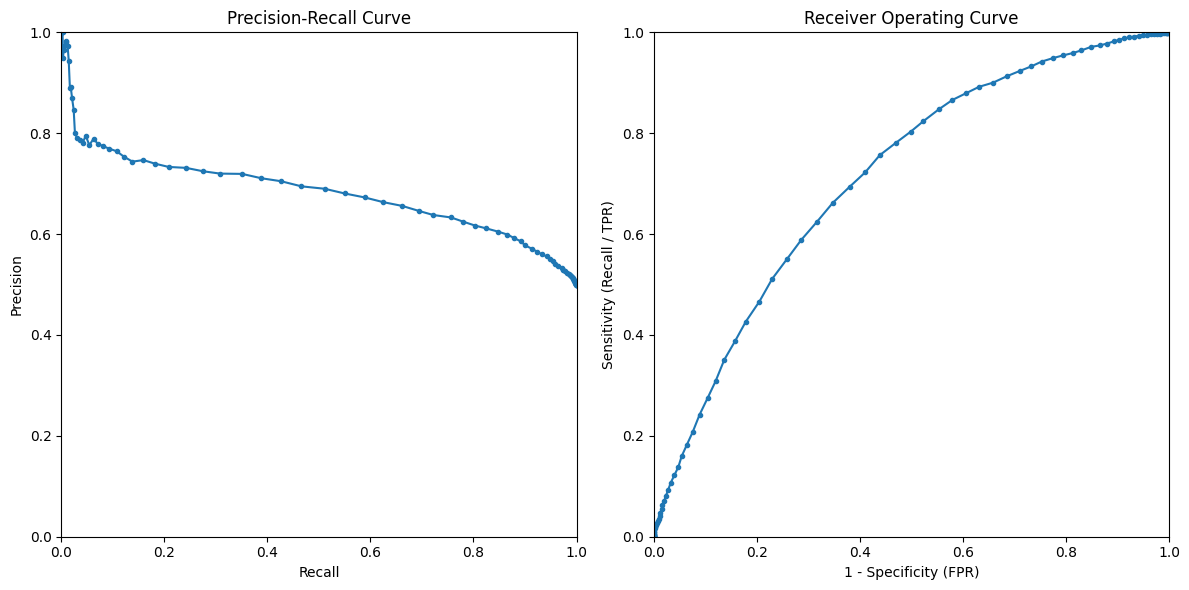

In [19]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, None)

### K = 2 sequence (= 60 mins) ("aggregate")

[[3331 2449]
 [1645 4135]]
              precision    recall  f1-score   support

           0       0.67      0.58      0.62      5780
           1       0.63      0.72      0.67      5780

    accuracy                           0.65     11560
   macro avg       0.65      0.65      0.64     11560
weighted avg       0.65      0.65      0.64     11560

AUROC: 0.7007728595203601
AUPRC: 0.65305429402933


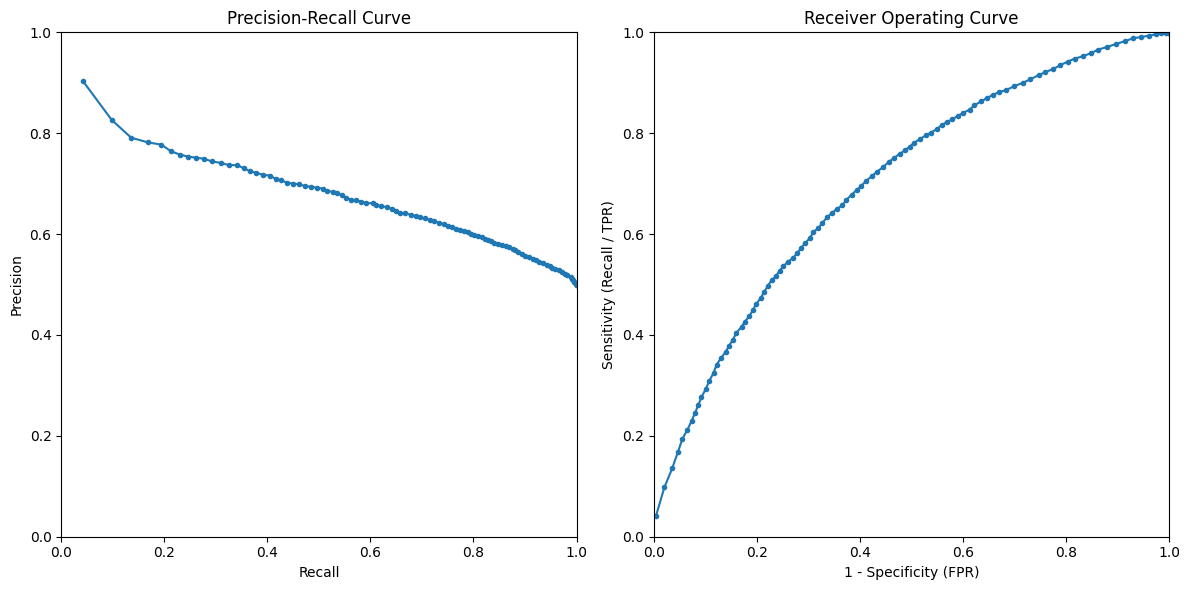

In [9]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, 2)

### EARLIEST ALARM TO ONSET TIME

[3.0, 0.5, -1.0, -2.5, -3.0]


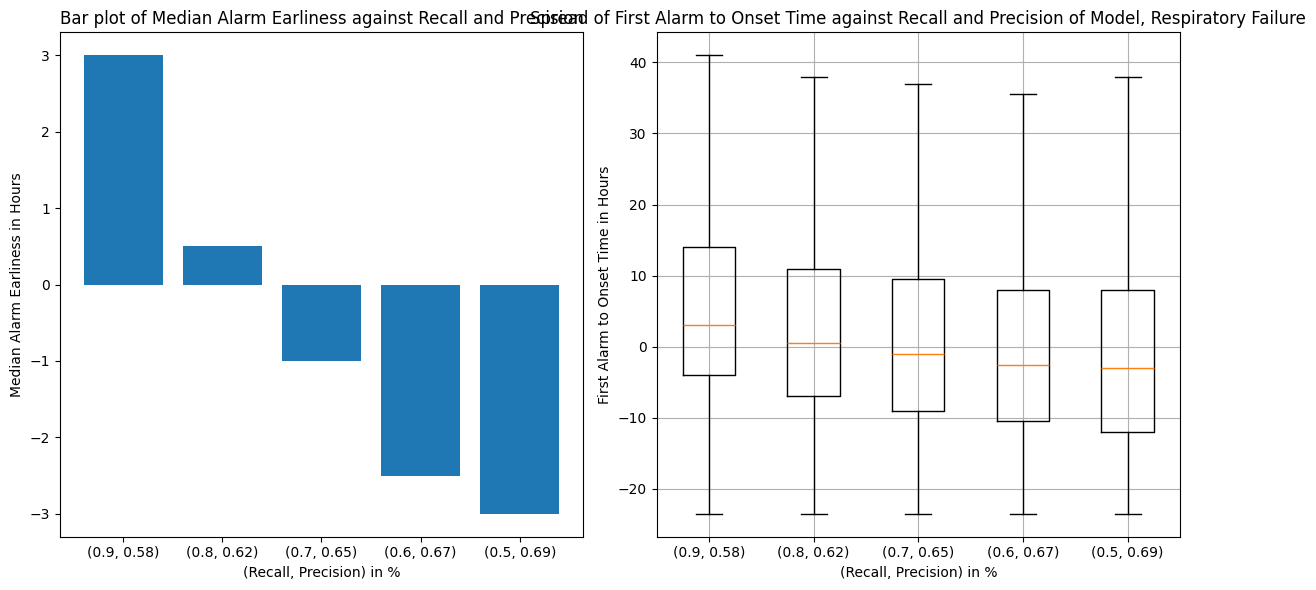

In [20]:
alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls)

## SHOCK - MIMIC

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

root_path = '/datasets/amelatur/whole_sequences/circulatory/k_fold/fold_4/'

predictions = np.load(root_path + 'raw_preds_online_lstm_6_24.npy')
targets = np.load(root_path + 'targets_test_6_24.npy')


final_patients = np.load(root_path + 'final_patients_test.npy')

labels_file = pd.read_csv(root_path + 'onset_index.csv', header=None, index_col=False).rename({0: 'Patient_ID', 1: 'Onset_Index'}, axis=1)

print(predictions.shape, targets.shape, final_patients.shape, labels_file.shape)   


(5815, 336, 1) (5815, 336, 1) (5815,) (35295, 2)


### No K-aggregates (first alarm raised only)

[[3637 1015]
 [ 498  665]]
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      4652
           1       0.40      0.57      0.47      1163

    accuracy                           0.74      5815
   macro avg       0.64      0.68      0.65      5815
weighted avg       0.78      0.74      0.76      5815

AUROC: 0.7467281706145861
AUPRC: 0.4313901575862357


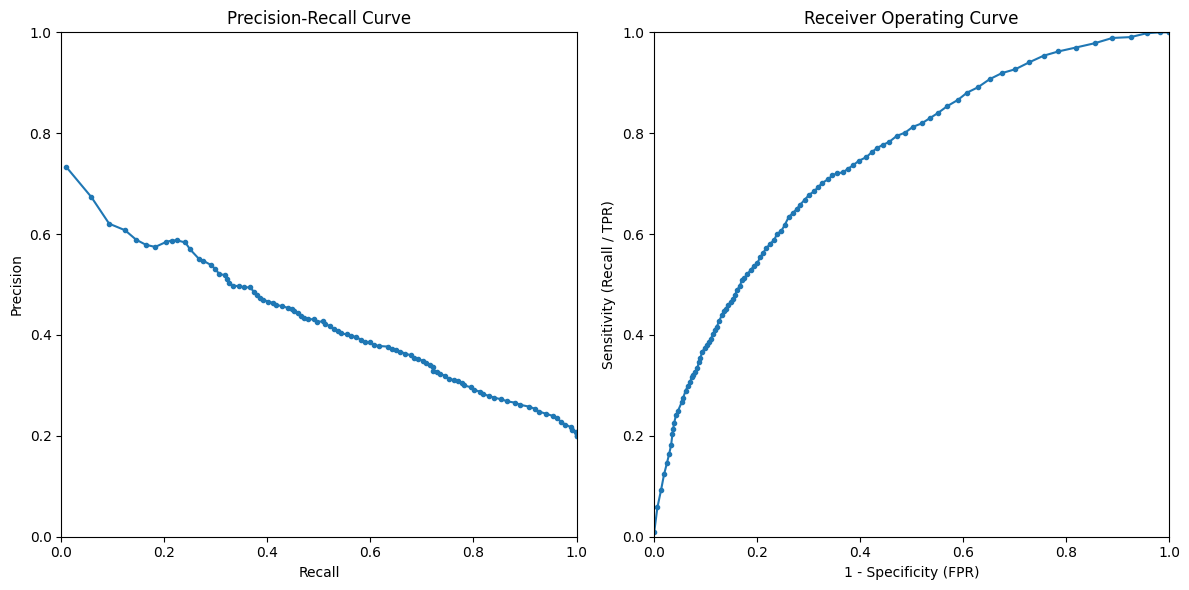

In [34]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, None)

### K = 6 sequence (= 30 mins) ("aggregate")

[[414 186]
 [ 36  84]]
              precision    recall  f1-score   support

           0       0.92      0.69      0.79       600
           1       0.31      0.70      0.43       120

    accuracy                           0.69       720
   macro avg       0.62      0.69      0.61       720
weighted avg       0.82      0.69      0.73       720

AUROC: 0.7512291666666666
AUPRC: 0.35511945584799354


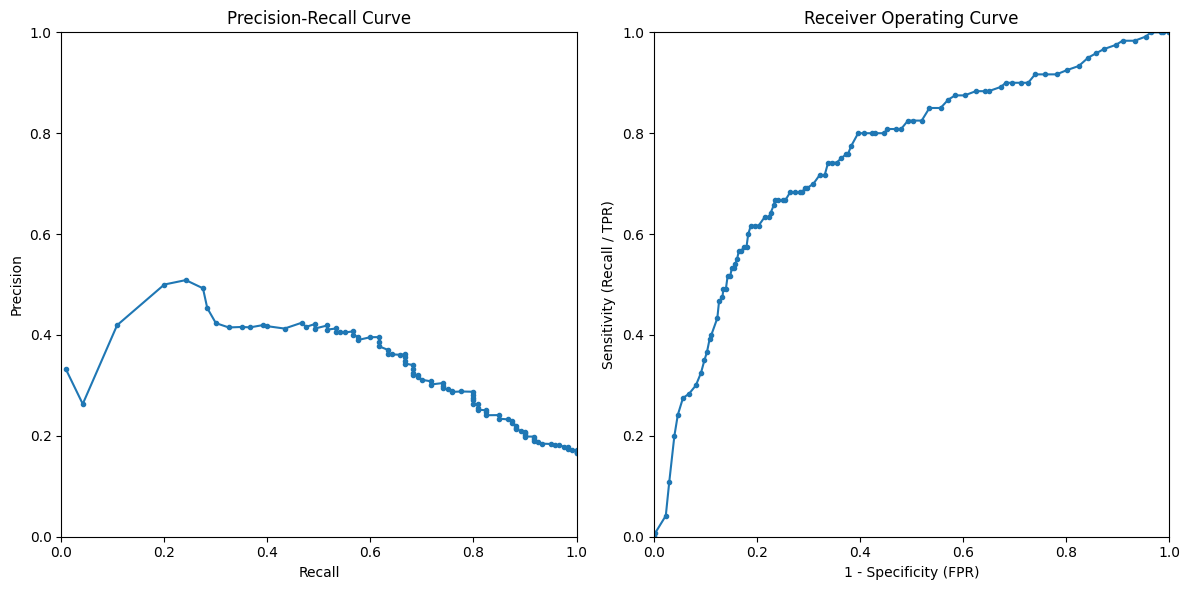

In [21]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, 6)

### EARLIEST ALARM TO ONSET TIME

[8.5, 6.5, 4.0, 2.5, 0.5]


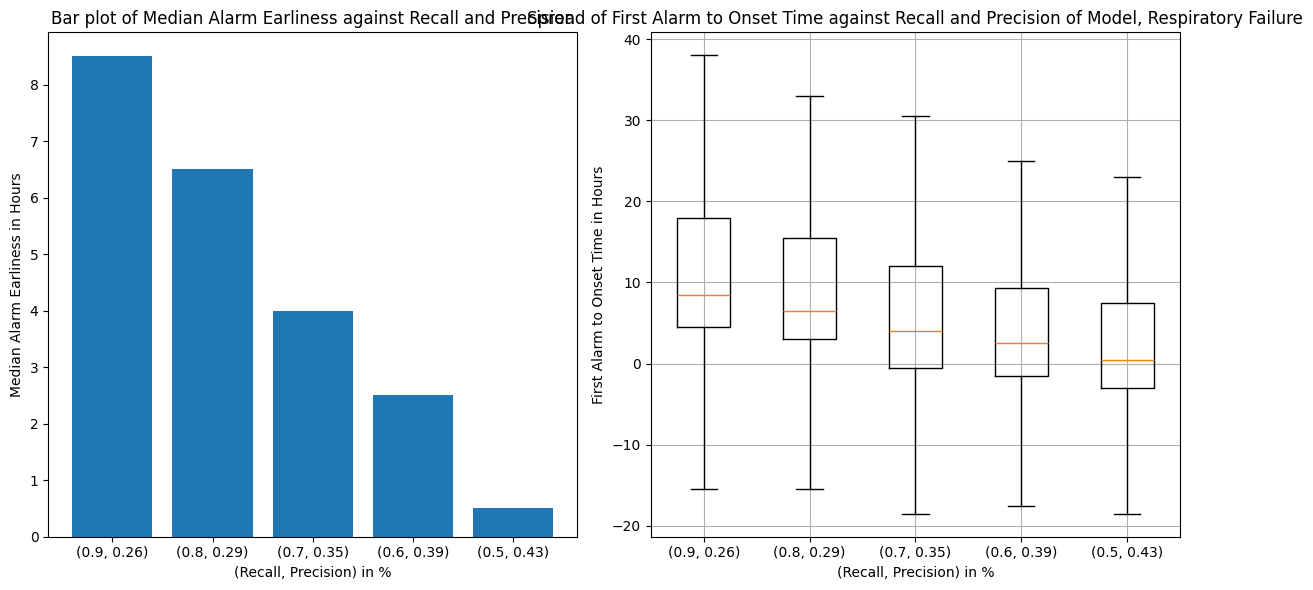

In [36]:
alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls)

## RESPIRATORY - EICU

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

root_path = '/datasets/amelatur/whole_sequences/respiratory_HiRID/k_fold/fold_4/'

predictions = np.load(root_path + 'raw_preds_online_lstm_6_24.npy')
targets = np.load(root_path + 'targets_test_6_24.npy')


final_patients = np.load(root_path + 'final_patients_test.npy')

labels_file = pd.read_csv(root_path + 'onset_index.csv', header=None, index_col=False).rename({0: 'Patient_ID', 1: 'Onset_Index'}, axis=1)

print(predictions.shape, targets.shape, final_patients.shape, labels_file.shape)   


(3348, 336, 1) (3348, 336, 1) (3348,) (22467, 2)


### No K-aggregates (first alarm raised only)

[[1489  185]
 [1386  288]]
              precision    recall  f1-score   support

           0       0.52      0.89      0.65      1674
           1       0.61      0.17      0.27      1674

    accuracy                           0.53      3348
   macro avg       0.56      0.53      0.46      3348
weighted avg       0.56      0.53      0.46      3348

AUROC: 0.5771203478886449
AUPRC: 0.5658836310626079


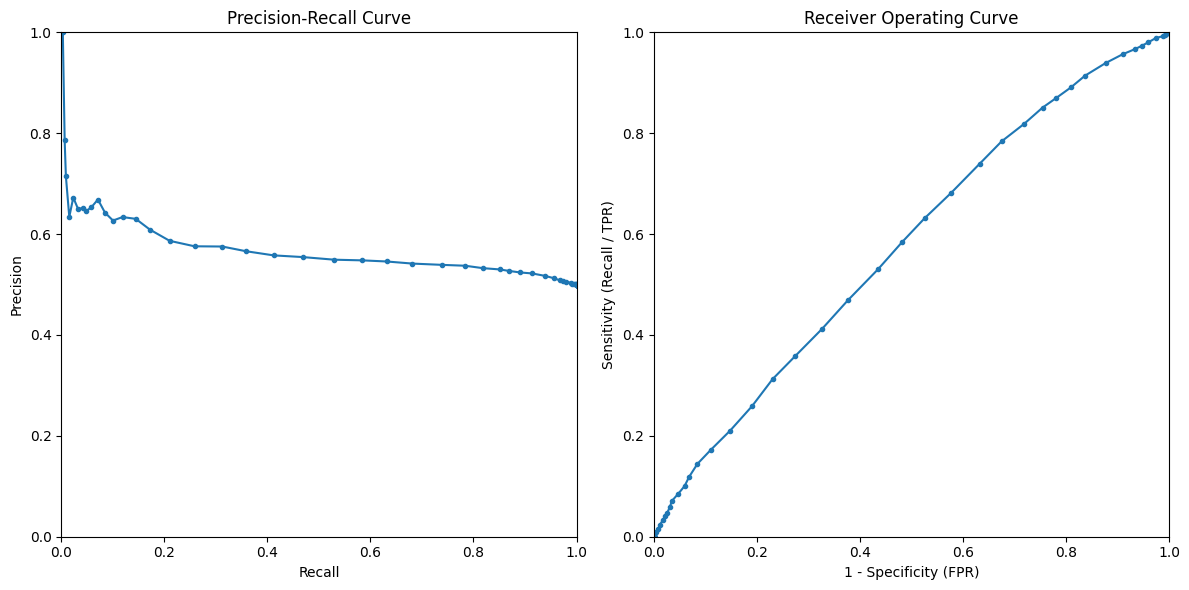

In [50]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, None)

### K = 2 sequence (= 60 mins) ("aggregate")

[[ 893  794]
 [ 558 1129]]
              precision    recall  f1-score   support

           0       0.62      0.53      0.57      1687
           1       0.59      0.67      0.63      1687

    accuracy                           0.60      3374
   macro avg       0.60      0.60      0.60      3374
weighted avg       0.60      0.60      0.60      3374

AUROC: 0.6504222287733986
AUPRC: 0.5133531950852865


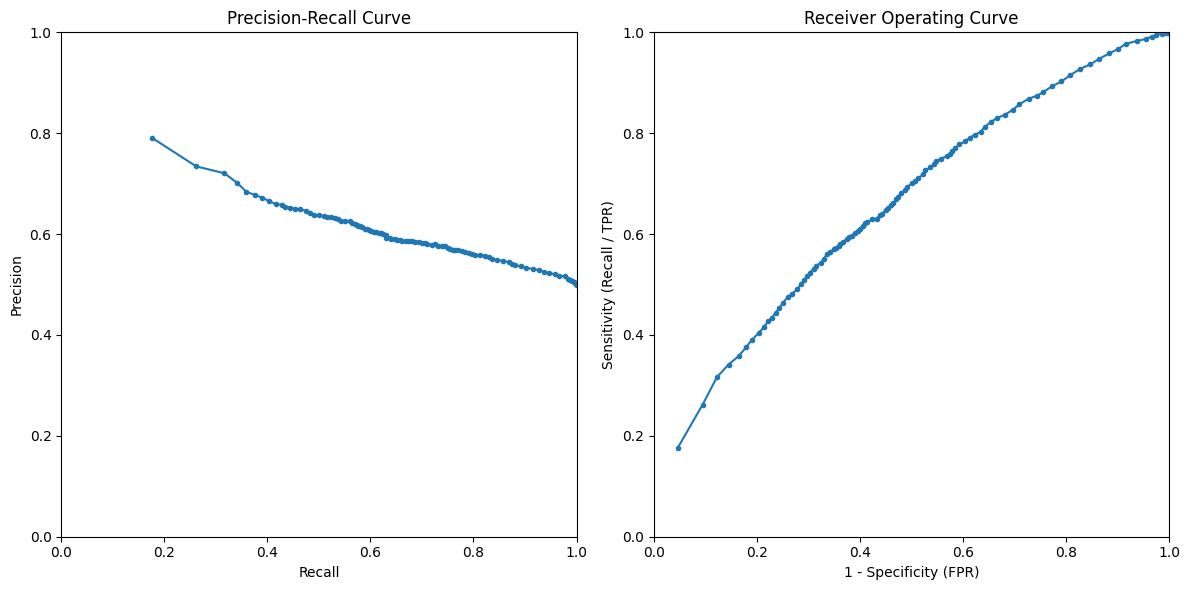

In [26]:
precisions, recalls, specificities, fpr_ls = eval(predictions, targets, 2)

### EARLIEST ALARM TO ONSET TIME

[3.0, 1.0, 0.5, 0.0, 0.0]


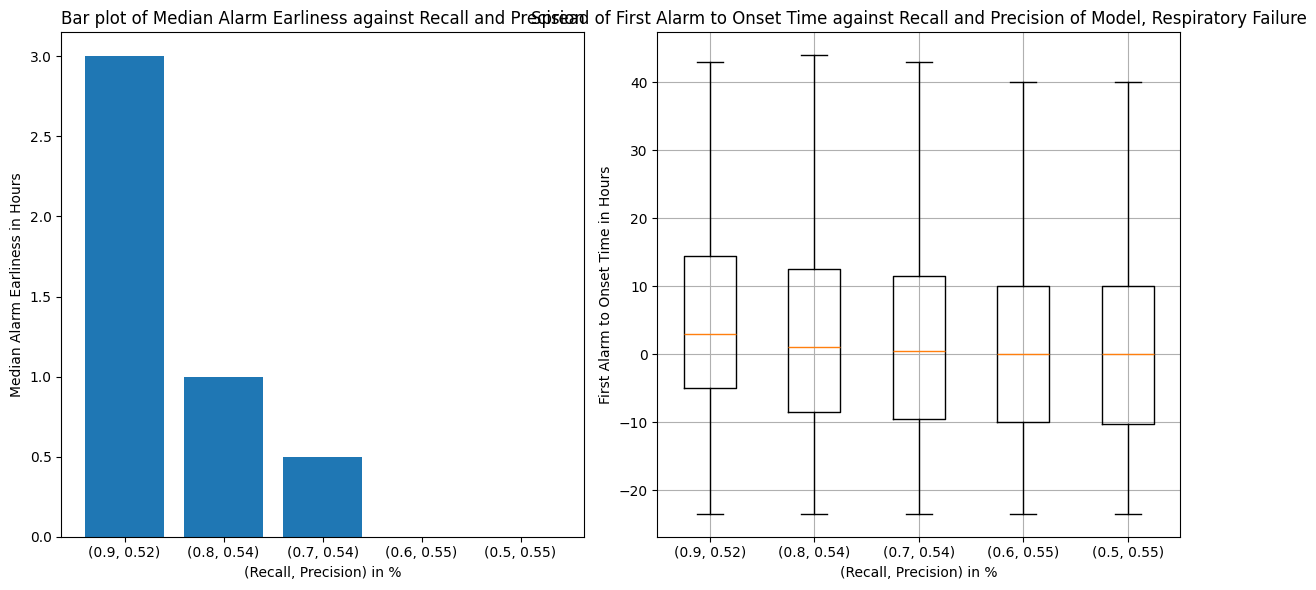

In [51]:
alarm_earliness(predictions, targets, labels_file, final_patients, precisions, recalls)